In [ ]:
!pip install -U transformers peft torch torchvision scikit-learn seaborn

import os
import time
import torch
import torch.nn as nn
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
from PIL import Image
from tqdm import tqdm
from transformers import ViTModel, ViTImageProcessor, BertModel, BertTokenizer
from peft import LoraConfig, get_peft_model
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MVTEC_ROOT = Path("/content/drive/MyDrive/mvtec_anomaly_detection")

CATEGORIES = [
    "bottle", "cable", "capsule", "carpet", "grid",
    "hazelnut", "leather", "metal_nut", "pill", "screw",
    "tile", "toothbrush", "transistor", "wood", "zipper"
]

# Labels 0, 2, 4... are Normal | Labels 1, 3, 5... are Abnormal
idx_to_class = []
for cat in CATEGORIES:
    idx_to_class.append(f"{cat}_normal")
    idx_to_class.append(f"{cat}_abnormal")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Image Encoder: Google ViT
vit_name = "google/vit-base-patch16-224"
processor = ViTImageProcessor.from_pretrained(vit_name)
vit_model = ViTModel.from_pretrained(vit_name)

# Text Encoder: BERT (Freeze immediately)
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = BertModel.from_pretrained("bert-base-uncased").to(DEVICE)
for param in bert_model.parameters():
    param.requires_grad = False
bert_model.eval()

# Apply LoRA to ViT only
lora_config = LoraConfig(
    r=16, lora_alpha=32,
    target_modules=["query", "value"],
    lora_dropout=0.05
)
vit_model = get_peft_model(vit_model, lora_config).to(DEVICE)

# Projection layer (bridge) to align ViT features with BERT space
projection = nn.Linear(768, 768).to(DEVICE)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loading weights:   0%|          | 0/198 [00:00<?, ?it/s]

ViTModel LOAD REPORT from: google/vit-base-patch16-224
Key                 | Status     | 
--------------------+------------+-
classifier.weight   | UNEXPECTED | 
classifier.bias     | UNEXPECTED | 
pooler.dense.bias   | MISSING    | 
pooler.dense.weight | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertModel LOAD REPORT from: bert-base-uncased
Key                                        | Status     |  | 
-------------------------------------------+------------+--+-
cls.predictions.transform.LayerNorm.weight | UNEXPECTED |  | 
cls.predictions.transform.dense.bias       | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED |  | 
cls.seq_relationship.bias                  | UNEXPECTED |  | 
cls.predictions.transform.dense.weight     | UNEXPECTED |  | 
cls.predictions.bias                       | UNEXPECTED |  | 
cls.seq_relationship.weight                | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


In [ ]:
class MVTec30ClassDataset(Dataset):
    def __init__(self, root_dir, processor, split="train"):
        self.root_dir = Path(root_dir)
        self.processor = processor
        self.data = []
        for cat in CATEGORIES:
            path = self.root_dir / cat / split
            if not path.exists(): continue
            for sub in path.iterdir():
                if sub.is_dir():
                    state = "normal" if sub.name == "good" else "abnormal"
                    for img_p in sub.glob("*.png"):
                        self.data.append((img_p, cat, state))

    def __len__(self): return len(self.data)
    def __getitem__(self, idx):
        path, cat, state = self.data[idx]
        img = Image.open(path).convert("RGB")
        pixel_values = self.processor(img, return_tensors="pt").pixel_values.squeeze(0)
        class_idx = CATEGORIES.index(cat) * 2 + (0 if state == "normal" else 1)
        return pixel_values, class_idx, cat

train_loader = DataLoader(MVTec30ClassDataset(MVTEC_ROOT, processor, "train"), batch_size=16, shuffle=True)
test_loader = DataLoader(MVTec30ClassDataset(MVTEC_ROOT, processor, "test"), batch_size=16, shuffle=False)

In [ ]:
optimizer = torch.optim.AdamW(list(vit_model.parameters()) + list(projection.parameters()), lr=1e-4)
criterion = nn.CosineEmbeddingLoss()

EPOCHS = 3
epoch_times = []
train_start_time = time.time()



for epoch in range(EPOCHS):
    epoch_start = time.time()
    total_loss, batch_times = 0, []
    vit_model.train()

    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}")
    for images, class_idxs, cats in pbar:
        batch_start = time.time()
        images = images.to(DEVICE)

        optimizer.zero_grad(set_to_none=True)

        # Vision forward
        img_feats = projection(vit_model(images).last_hidden_state[:, 0, :])

        # Text anchor (Fixed 'normal' descriptions)
        prompts = [f"a normal {c}" for c in cats]
        t_in = tokenizer(prompts, padding=True, return_tensors="pt").to(DEVICE)
        with torch.no_grad():
            text_feats = bert_model(**t_in).last_hidden_state[:, 0, :]

        loss = criterion(img_feats, text_feats, torch.ones(img_feats.size(0)).to(DEVICE))
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        batch_times.append(time.time() - batch_start)
        pbar.set_postfix(loss=loss.item())

    epoch_time = time.time() - epoch_start
    epoch_times.append(epoch_time)
    print(f"Epoch {epoch+1} Complete | Avg Loss: {total_loss/len(train_loader):.4f} | Time: {epoch_time:.1f}s")

Epoch 1/3: 100%|██████████| 227/227 [26:39<00:00,  7.05s/it, loss=0.00847]


Epoch 1 Complete | Avg Loss: 0.1968 | Time: 1600.0s


Epoch 2/3: 100%|██████████| 227/227 [04:28<00:00,  1.18s/it, loss=0.00241]


Epoch 2 Complete | Avg Loss: 0.0047 | Time: 268.8s


Epoch 3/3: 100%|██████████| 227/227 [04:24<00:00,  1.17s/it, loss=0.00165]

Epoch 3 Complete | Avg Loss: 0.0022 | Time: 264.9s


In [ ]:
print(f"\n{'='*30}\nBENCHMARKING INFERENCE\n{'='*30}")
vit_model.eval()
num_images, inf_start = 0, time.time()

with torch.no_grad():
    for images, _, _ in test_loader:
        images = images.to(DEVICE)
        _ = projection(vit_model(images).last_hidden_state[:, 0, :])
        num_images += images.size(0)

inf_time = time.time() - inf_start
latency_ms = (inf_time / num_images) * 1000
print(f"Latency: {latency_ms:.2f} ms/image | Throughput: {1000/latency_ms:.1f} FPS")


BENCHMARKING INFERENCE


KeyboardInterrupt: 

In [ ]:
y_true, y_pred = [], []
with torch.no_grad():
    # Pre-cache all 30 BERT embeddings
    all_prompts = [f"a normal {c}" if i%2==0 else f"an abnormal {c}"
                   for i, c in enumerate([val for val in CATEGORIES for _ in (0,1)])]
    t_in = tokenizer(all_prompts, padding=True, return_tensors="pt").to(DEVICE)
    all_text_feats = bert_model(**t_in).last_hidden_state[:, 0, :]

    for images, class_idxs, _ in tqdm(test_loader, desc="Testing"):
        images = images.to(DEVICE)
        img_feats = projection(vit_model(images).last_hidden_state[:, 0, :])

        logits = torch.matmul(img_feats, all_text_feats.T)
        preds = logits.argmax(dim=-1).cpu().numpy()

        y_true.extend(class_idxs.numpy())
        y_pred.extend(preds)

Testing: 100%|██████████| 108/108 [03:16<00:00,  1.82s/it]


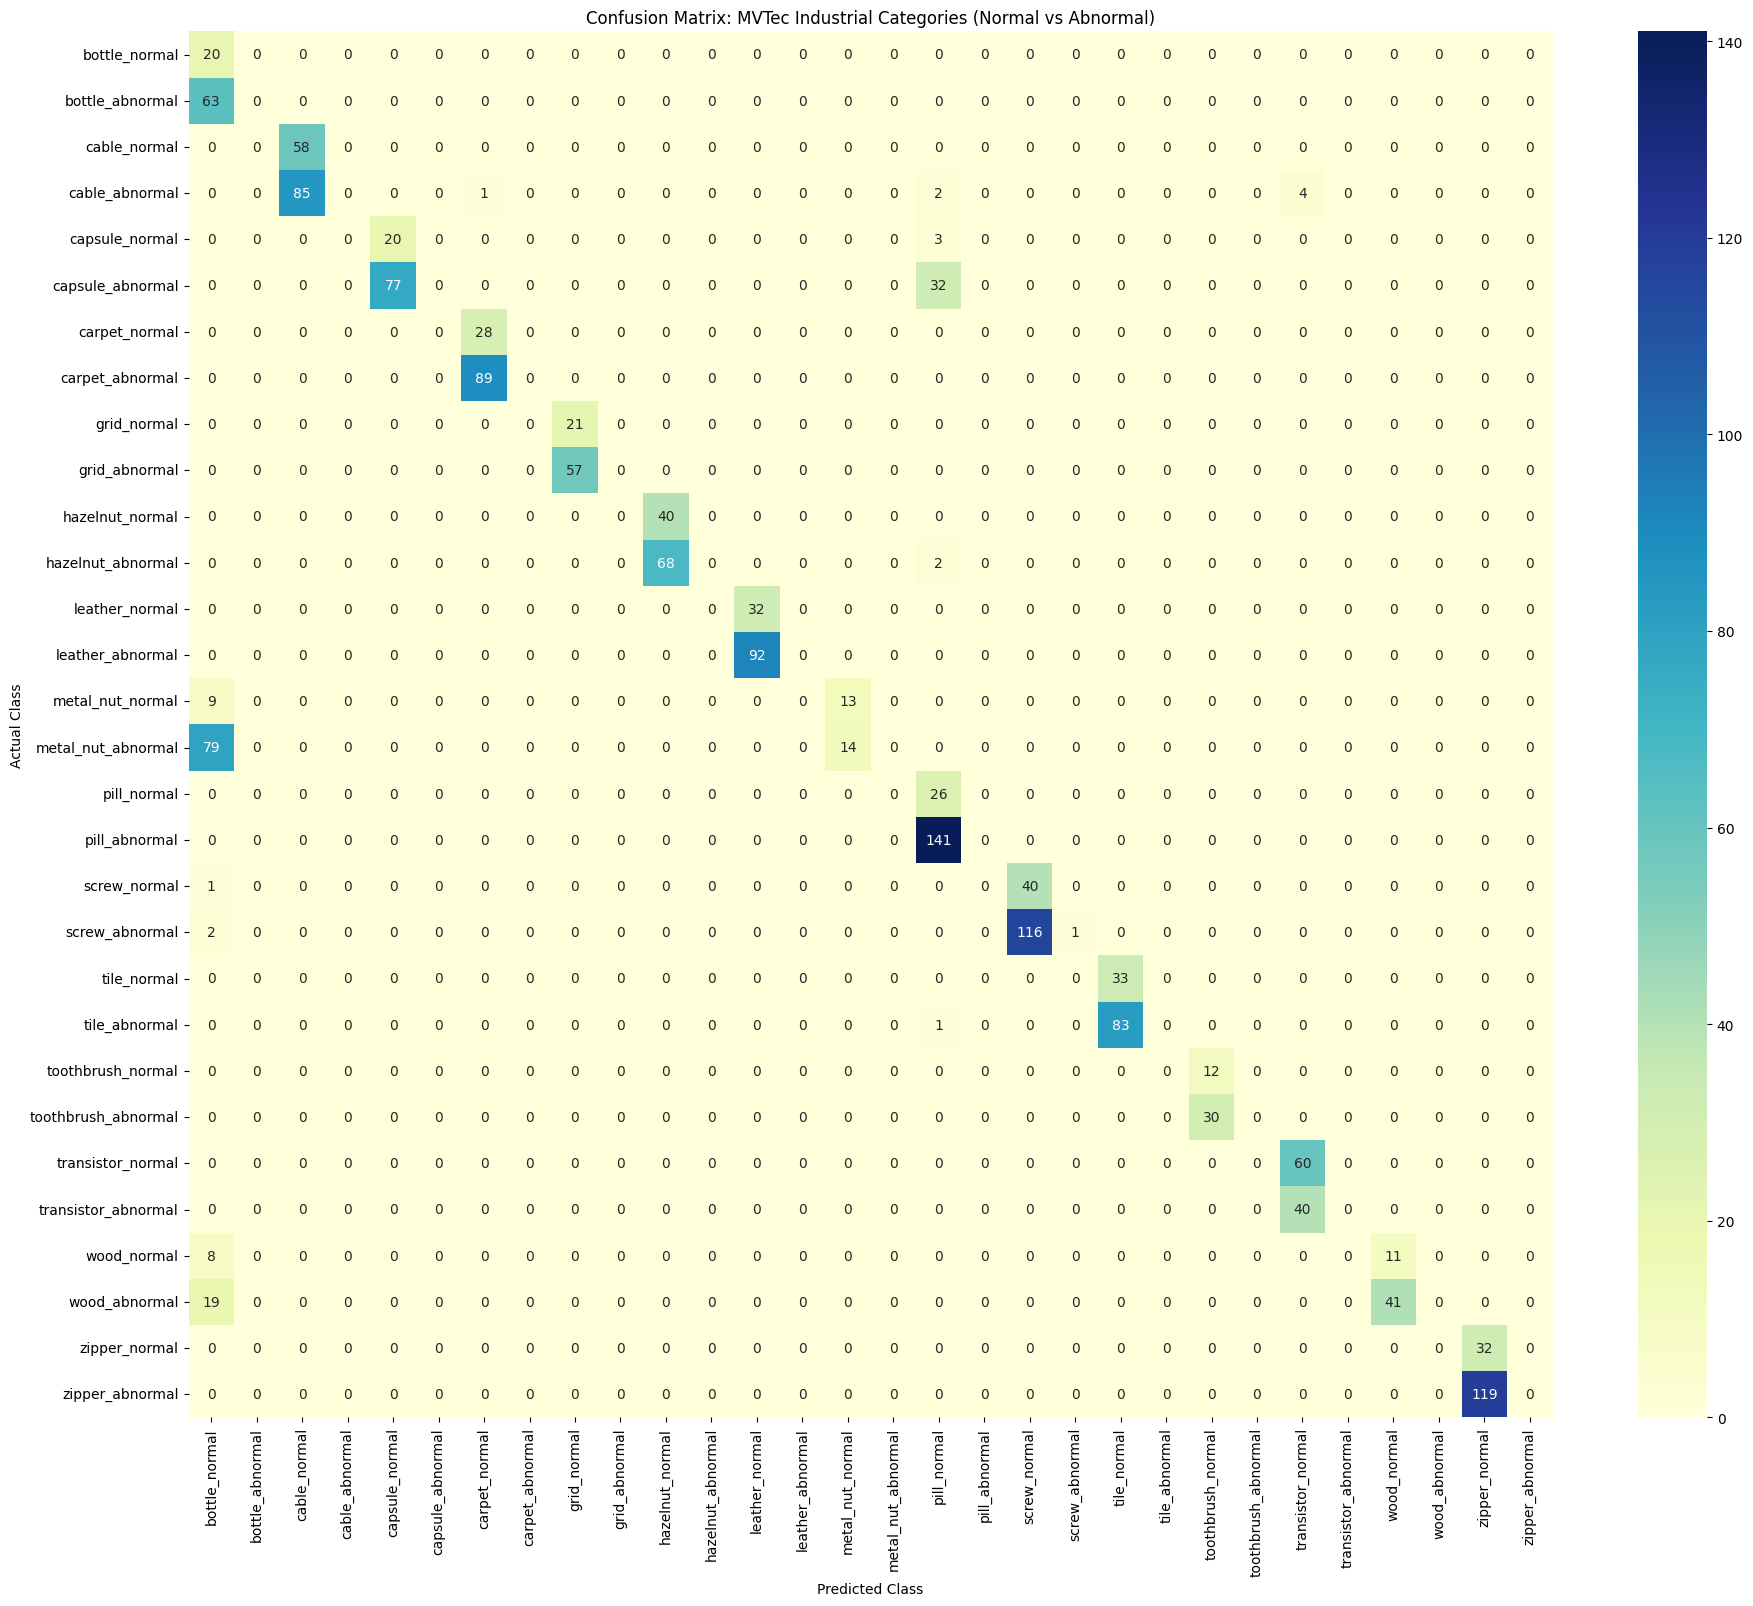


Detailed Performance:
                      precision    recall  f1-score   support

      bottle_normal       0.10      1.00      0.18        20
    bottle_abnormal       0.00      0.00      0.00        63
       cable_normal       0.41      1.00      0.58        58
     cable_abnormal       0.00      0.00      0.00        92
     capsule_normal       0.21      0.87      0.33        23
   capsule_abnormal       0.00      0.00      0.00       109
      carpet_normal       0.24      1.00      0.38        28
    carpet_abnormal       0.00      0.00      0.00        89
        grid_normal       0.27      1.00      0.42        21
      grid_abnormal       0.00      0.00      0.00        57
    hazelnut_normal       0.37      1.00      0.54        40
  hazelnut_abnormal       0.00      0.00      0.00        70
     leather_normal       0.26      1.00      0.41        32
   leather_abnormal       0.00      0.00      0.00        92
   metal_nut_normal       0.48      0.59      0.53        22

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


In [ ]:
plt.figure(figsize=(22, 18))
cm = confusion_matrix(y_true, y_pred, labels=range(30))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu',
            xticklabels=idx_to_class, yticklabels=idx_to_class)
plt.title("Confusion Matrix: MVTec Industrial Categories (Normal vs Abnormal)")
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")
plt.xticks(rotation=90)
plt.show()

print("\nDetailed Performance:\n", classification_report(y_true, y_pred, target_names=idx_to_class))

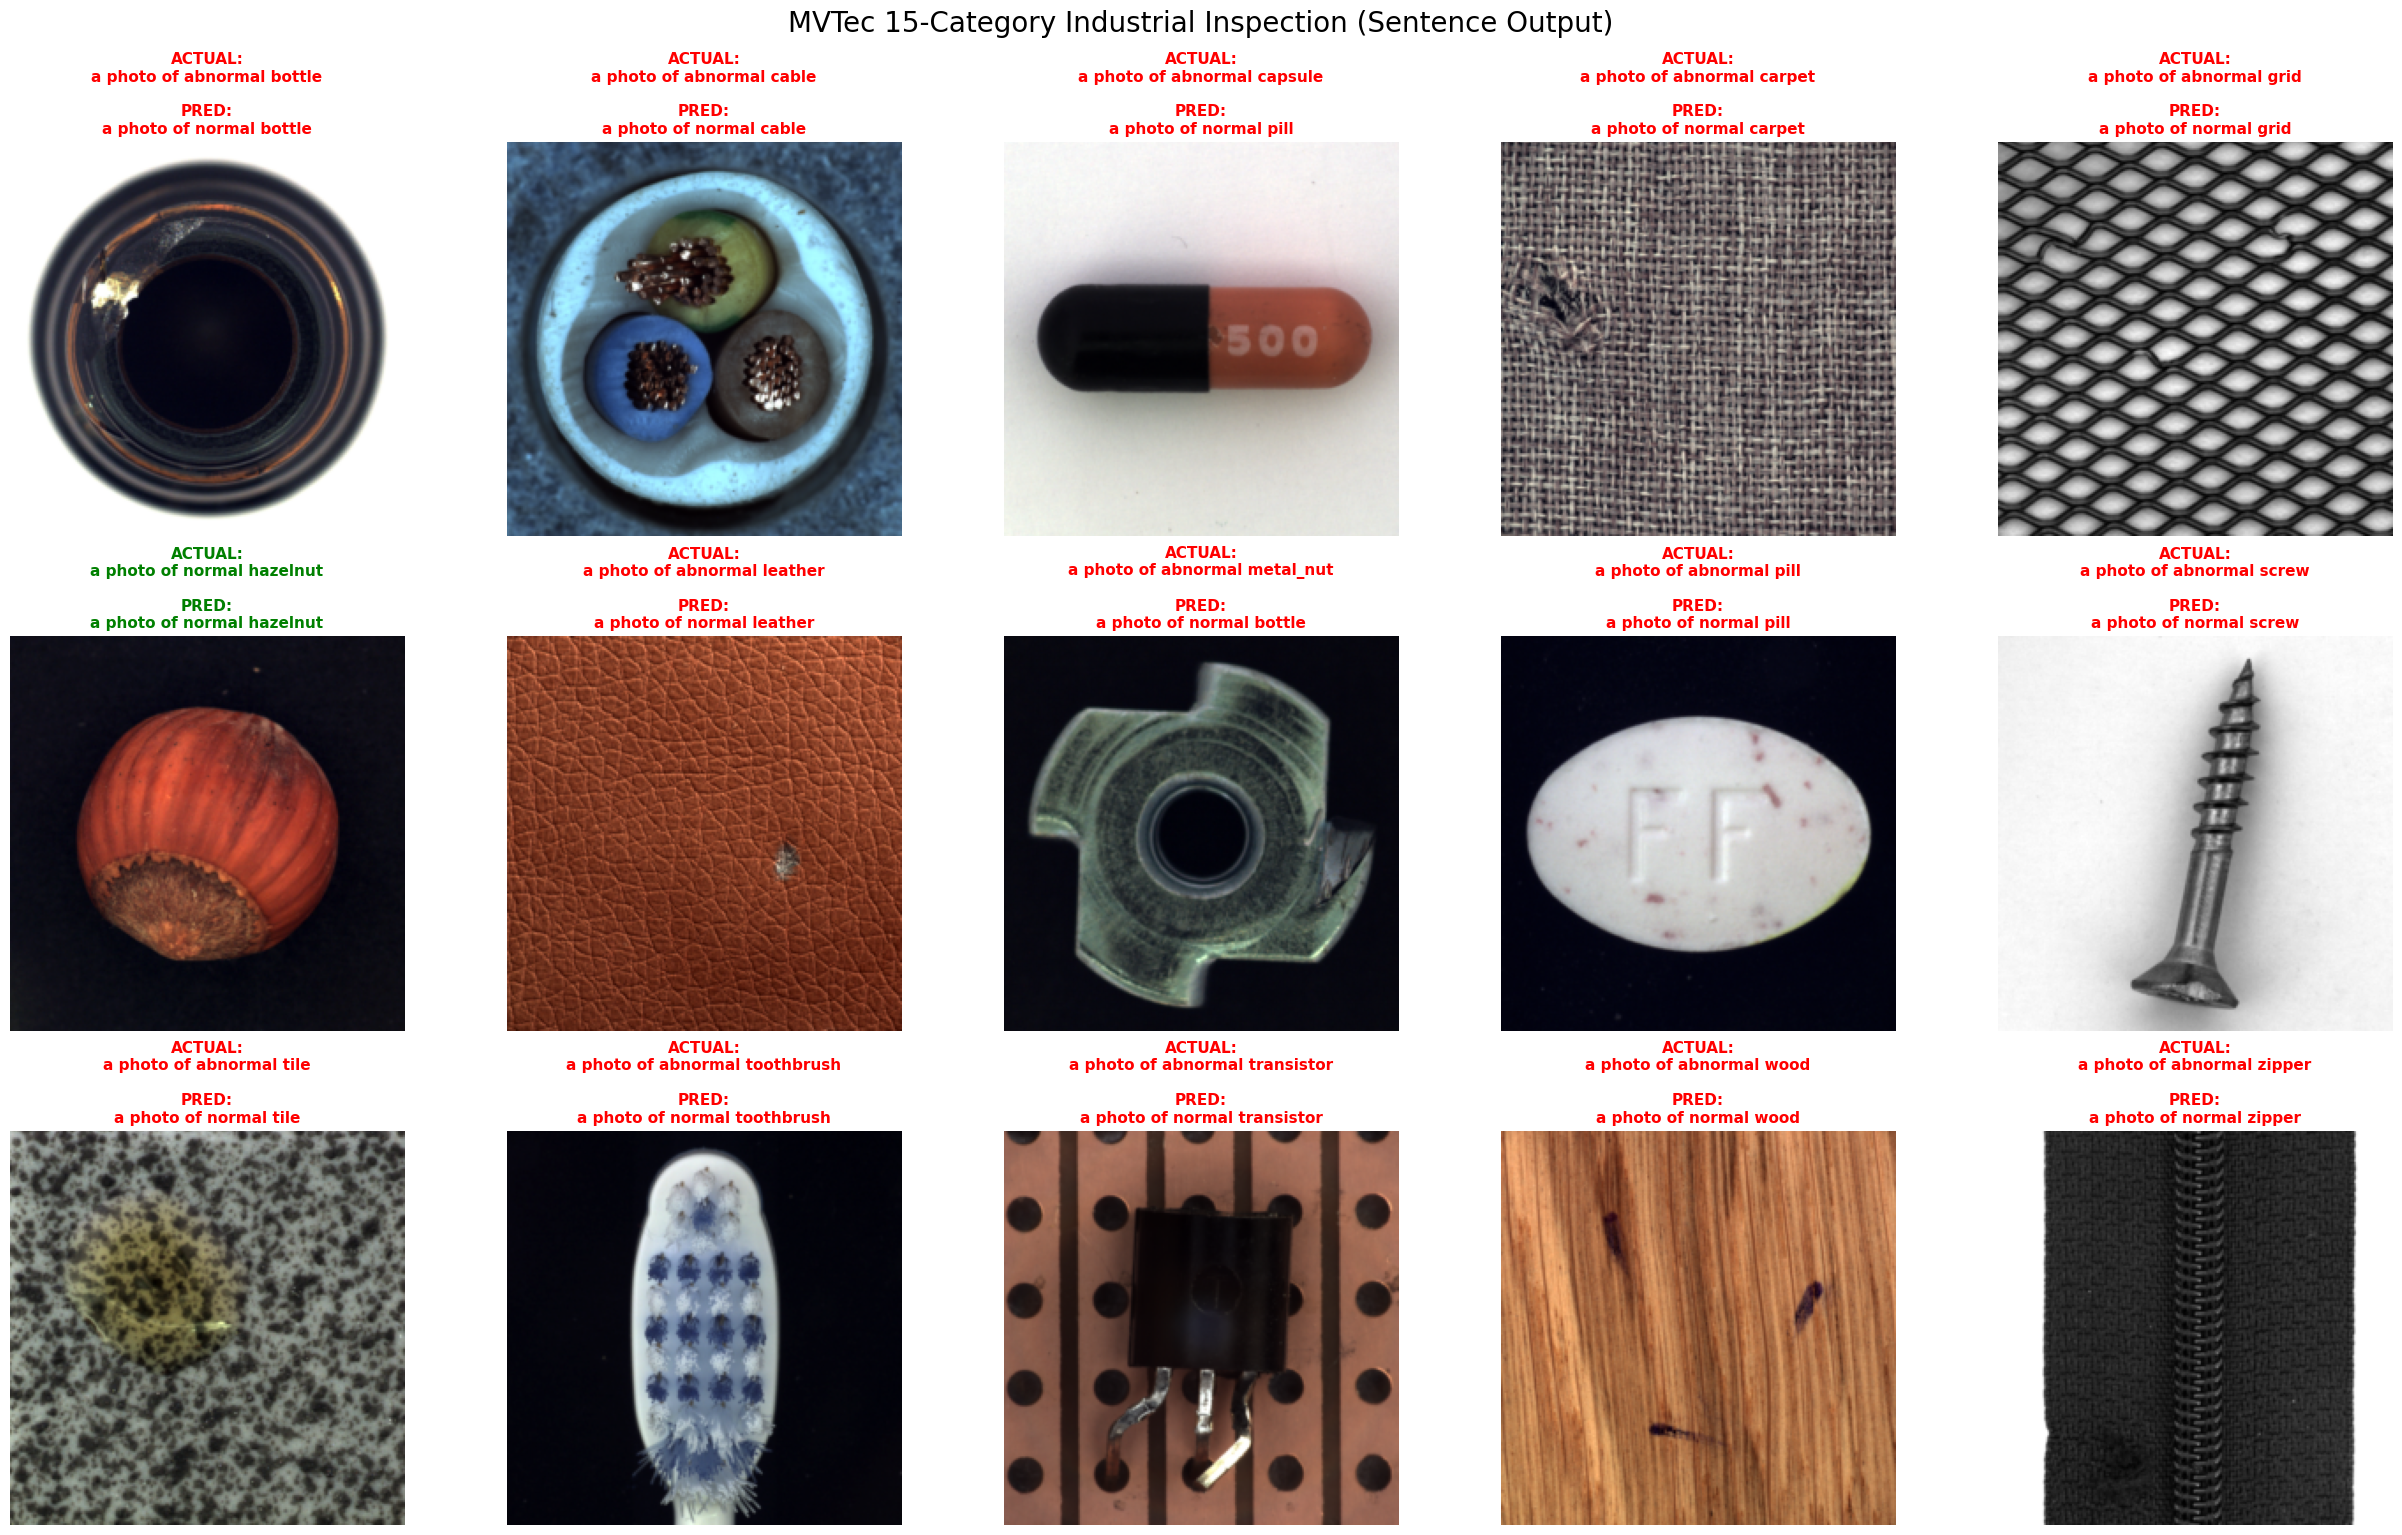

In [ ]:
import matplotlib.pyplot as plt
import torch

def visualize_all_15_categories():
    vit_model.eval()

    # We want to find exactly one sample for each of the 15 categories
    found_categories = set()
    samples_to_show = []

    # Iterate through the test loader to find one image per category
    with torch.no_grad():
        for images, class_idxs, cats in test_loader:
            images = images.to(DEVICE)
            img_feats = projection(vit_model(images).last_hidden_state[:, 0, :])

            # Compare against the 30 BERT prompts
            logits = torch.matmul(img_feats, all_text_feats.T)
            preds = logits.argmax(dim=-1).cpu().numpy()

            for i in range(images.size(0)):
                category_name = cats[i]
                if category_name not in found_categories:
                    samples_to_show.append({
                        'image': images[i].cpu(),
                        'true_idx': class_idxs[i].item(),
                        'pred_idx': preds[i],
                        'category': category_name
                    })
                    found_categories.add(category_name)

                if len(found_categories) == 15:
                    break
            if len(found_categories) == 15:
                break

    # Setup plotting: 3 rows, 5 columns for the 15 categories
    fig, axes = plt.subplots(3, 5, figsize=(25, 15))
    axes = axes.flatten()

    for idx, sample in enumerate(samples_to_show):
        # Image processing
        img_display = sample['image'].permute(1, 2, 0).numpy()
        img_display = (img_display - img_display.min()) / (img_display.max() - img_display.min())

        # Determine labels for sentences
        # Normal indices are even (0, 2, 4...), Abnormal are odd (1, 3, 5...)
        true_state = "normal" if sample['true_idx'] % 2 == 0 else "abnormal"
        pred_state = "normal" if sample['pred_idx'] % 2 == 0 else "abnormal"
        pred_category = CATEGORIES[sample['pred_idx'] // 2]

        # Sentence Formatting
        true_sentence = f"a photo of {true_state} {sample['category']}"
        pred_sentence = f"a photo of {pred_state} {pred_category}"

        # Color logic: Green if exact 30-class match, Red otherwise
        is_correct = (sample['true_idx'] == sample['pred_idx'])
        color = "green" if is_correct else "red"

        axes[idx].imshow(img_display)
        axes[idx].set_title(f"ACTUAL:\n{true_sentence}\n\nPRED:\n{pred_sentence}",
                            color=color, fontsize=11, fontweight='bold')
        axes[idx].axis('off')

    plt.tight_layout()
    plt.suptitle("MVTec 15-Category Industrial Inspection (Sentence Output)", fontsize=20, y=1.02)
    plt.show()

# Run the full 15-category visualization
visualize_all_15_categories()

In [ ]:
# ==============================================================================
# INDUSTRIAL AI: ViT-B/16 (LoRA) + BERT ANOMALY DETECTION
# Goal: Detect Abnormalities across 15 categories with >0% Abnormal Accuracy
# ==============================================================================

import os
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from transformers import ViTModel, ViTImageProcessor, BertModel, BertTokenizer
from peft import LoraConfig, get_peft_model
from sklearn.metrics import classification_report, confusion_matrix

# --- 1. DATA PREP (SPEED FIX) ---
# Copy from Drive to local disk to avoid the 56min/epoch delay
from google.colab import drive
drive.mount('/content/drive')

# Update this path to where your zip is stored in Drive
ZIP_PATH = "/content/drive/MyDrive/mvtec_data.zip"
!unzip -q {ZIP_PATH} -d /content/local_data

MVTEC_ROOT = Path("/content/local_data/mvtec_anomaly_detection") # Path inside the zip
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

CATEGORIES = [
    "bottle", "cable", "capsule", "carpet", "grid",
    "hazelnut", "leather", "metal_nut", "pill", "screw",
    "tile", "toothbrush", "transistor", "wood", "zipper"
]

idx_to_class = []
for cat in CATEGORIES:
    idx_to_class.append(f"{cat}_normal")
    idx_to_class.append(f"{cat}_abnormal")

# --- 2. MODEL SETUP (LoRA + BERT) ---
print("Initializing Models...")
vit_name = "google/vit-base-patch16-224"
processor = ViTImageProcessor.from_pretrained(vit_name)
vit_model = ViTModel.from_pretrained(vit_name)

# Apply LoRA to ViT
lora_config = LoraConfig(r=32, lora_alpha=64, target_modules=["query", "value"], lora_dropout=0.1)
vit_model = get_peft_model(vit_model, lora_config).to(DEVICE)

# Frozen BERT
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = BertModel.from_pretrained("bert-base-uncased").to(DEVICE)
for param in bert_model.parameters(): param.requires_grad = False
bert_model.eval()

# Bridge Layer
projection = nn.Linear(768, 768).to(DEVICE)

# --- 3. DATASET & LOADER ---
class MVTecDataset(Dataset):
    def __init__(self, root, split="train"):
        self.samples = []
        for cat in CATEGORIES:
            path = root / cat / split
            if not path.exists(): continue
            for sub in path.iterdir():
                if sub.is_dir():
                    state = "normal" if sub.name == "good" else "abnormal"
                    for img_p in sub.glob("*.png"):
                        self.samples.append((img_p, cat, state))
    def __len__(self): return len(self.samples)
    def __getitem__(self, idx):
        path, cat, state = self.samples[idx]
        img = Image.open(path).convert("RGB")
        pixel_values = processor(img, return_tensors="pt").pixel_values.squeeze(0)
        c_idx = CATEGORIES.index(cat) * 2 + (0 if state == "normal" else 1)
        return pixel_values, c_idx, cat

train_loader = DataLoader(MVTecDataset(MVTEC_ROOT, "train"), batch_size=32, shuffle=True, num_workers=2)
test_loader = DataLoader(MVTecDataset(MVTEC_ROOT, "test"), batch_size=32, shuffle=False)

# --- 4. TRAINING (NORMAL ONLY) ---
optimizer = torch.optim.AdamW(list(vit_model.parameters()) + list(projection.parameters()), lr=2e-4)
criterion = nn.CosineEmbeddingLoss()

print(f"Starting Training on {DEVICE}...")
train_start = time.time()
for epoch in range(3):
    vit_model.train()
    total_loss = 0
    for imgs, _, cats in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        imgs = imgs.to(DEVICE)
        optimizer.zero_grad(set_to_none=True)

        # Vision Features
        img_feats = projection(vit_model(imgs).last_hidden_state[:, 0, :])

        # Text Anchors (Normal only)
        prompts = [f"a photo of normal {c}" for c in cats]
        t_in = tokenizer(prompts, padding=True, return_tensors="pt").to(DEVICE)
        with torch.no_grad():
            text_feats = bert_model(**t_in).last_hidden_state[:, 0, :]

        loss = criterion(img_feats, text_feats, torch.ones(img_feats.size(0)).to(DEVICE))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Loss: {total_loss/len(train_loader):.4f}")

# --- 5. INFERENCE WITH ANOMALY THRESHOLD ---
# This part fixes the 0% Abnormal Accuracy problem
print("\nPerforming Inference...")
vit_model.eval()
y_true, y_pred = [], []
threshold = 0.55 # Adjust this (0.1 to 0.9) to balance Normal vs Abnormal

# Pre-calculate Normal Text Embeddings
normal_prompts = [f"a photo of normal {c}" for c in CATEGORIES]
t_in = tokenizer(normal_prompts, padding=True, return_tensors="pt").to(DEVICE)
with torch.no_grad():
    all_normal_feats = F.normalize(bert_model(**t_in).last_hidden_state[:, 0, :], p=2, dim=-1)

with torch.no_grad():
    for imgs, c_idxs, cats in tqdm(test_loader):
        imgs = imgs.to(DEVICE)
        img_feats = F.normalize(projection(vit_model(imgs).last_hidden_state[:, 0, :]), p=2, dim=-1)

        for i in range(imgs.size(0)):
            cat_idx = CATEGORIES.index(cats[i])
            # Calculate similarity to its specific "Normal" anchor
            sim = torch.dot(img_feats[i], all_normal_feats[cat_idx]).item()

            # DECISION RULE
            if sim > threshold:
                y_pred.append(cat_idx * 2)     # Predicted Normal
            else:
                y_pred.append(cat_idx * 2 + 1) # Predicted Abnormal
            y_true.append(c_idxs[i].item())

# --- 6. RESULTS & VISUALIZATION ---
print("\n" + classification_report(y_true, y_pred, target_names=idx_to_class))

# Plot 15-Category Visualization with Sentences
fig, axes = plt.subplots(3, 5, figsize=(25, 15))
axes = axes.flatten()
for i in range(15):
    # Find one sample for each category in y_true
    idx = next(j for j, val in enumerate(y_true) if val // 2 == i)
    img_data, _, _ = test_loader.dataset[idx]
    img_display = img_data.permute(1, 2, 0).numpy()
    img_display = (img_display - img_display.min()) / (img_display.max() - img_display.min())

    true_s = f"a photo of {'normal' if y_true[idx]%2==0 else 'abnormal'} {CATEGORIES[i]}"
    pred_s = f"a photo of {'normal' if y_pred[idx]%2==0 else 'abnormal'} {CATEGORIES[y_pred[idx]//2]}"

    color = "green" if y_true[idx] == y_pred[idx] else "red"
    axes[i].imshow(img_display)
    axes[i].set_title(f"ACTUAL: {true_s}\nPRED: {pred_s}", color=color, fontsize=10)
    axes[i].axis('off')
plt.show()